In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import textblob
from textblob import TextBlob, Word
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
import string
table = str.maketrans('', '', string.punctuation)
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.stem import wordnet
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
word_lem = WordNetLemmatizer()
from textblob import TextBlob

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def read_dataset():
    data = pd.read_csv(r"/content/drive/MyDrive/Data Set Suicidal/unprocessed.csv", sep = '\t', header = None)
    data.columns = ['sentence', 'labels']
    return data

In [ ]:
def sample_data(data, sample_value):
    data = data[:][:sample_value]
    return data

In [ ]:
print(read_dataset())

                                                 sentence  labels
0       I’m having anxiety right now and it’s not goin...       0
1       Its been a hard hard week for me, i decided to...       0
2       I was extremely suicidal 8 months ago. I reali...       1
3       After a long and terrible relationship and not...       0
4       Specifically against Yunkai and Astapor. Two c...       0
...                                                   ...     ...
207417  The love of my life is slowly drifting away fr...       1
207418  Because of all the shit that is happening in t...       1
207419  Kind of an oddball question, but for anybody w...       1
207420  The thought of taking exams is triggering suic...       1
207421  I havent been clinically/psychologically diagn...       0

[207422 rows x 2 columns]


In [ ]:
data = read_dataset()

In [ ]:
print(data)

                                                 sentence  labels
0       I’m having anxiety right now and it’s not goin...       0
1       Its been a hard hard week for me, i decided to...       0
2       I was extremely suicidal 8 months ago. I reali...       1
3       After a long and terrible relationship and not...       0
4       Specifically against Yunkai and Astapor. Two c...       0
...                                                   ...     ...
207417  The love of my life is slowly drifting away fr...       1
207418  Because of all the shit that is happening in t...       1
207419  Kind of an oddball question, but for anybody w...       1
207420  The thought of taking exams is triggering suic...       1
207421  I havent been clinically/psychologically diagn...       0

[207422 rows x 2 columns]


In [ ]:
def avg_word_len (sentence):
    words = sentence.split()
    avg_len = sum(len(word) for word in words)/len(words)
    return avg_len

def extract_ngrams(data, num):
    '''
    Function to generate n-grams from sentences
    '''
    n_grams = TextBlob(data).ngrams(num)
    return [ ' '.join(grams) for grams in n_grams]

In [ ]:
print(data.shape)
data.head()

(207422, 2)


,sentence,labels
0,I’m having anxiety right now and it’s not goin...,0
1,"Its been a hard hard week for me, i decided to...",0
2,I was extremely suicidal 8 months ago. I reali...,1
3,After a long and terrible relationship and not...,0
4,Specifically against Yunkai and Astapor. Two c...,0


In [ ]:
data['char_count'] = data['sentence'].str.len()
df_train_sort_charcount = data.sort_values(by='char_count', ascending=False)
df_train_sort_charcount[['sentence', 'char_count']].head()

,sentence,char_count
95803,https://www.evernote.com/shard/s405/sh/cb9e84c...,39883
52839,Felicia: [Part 1](https://www.reddit.com/r/nos...,39366
117650,Some may remember me. I was asked what’s going...,37055
117543,"Microwave, Penicillin, chocolate chip cookies,...",36819
91805,\[Before I post this: this turned out way long...,36788


In [ ]:
data['word_count'] = data['sentence'].apply(lambda x: len(str(x).split(" ")))
df_train_sort_wordcount = data.sort_values(by='word_count', ascending=False)
df_train_sort_wordcount[['sentence','word_count']].head()

,sentence,word_count
95803,https://www.evernote.com/shard/s405/sh/cb9e84c...,7115
117650,Some may remember me. I was asked what’s going...,7027
91805,\[Before I post this: this turned out way long...,6707
186512,I’m an avid explorer. For as long as I can rem...,6518
117543,"Microwave, Penicillin, chocolate chip cookies,...",6512


In [ ]:
data = data['sentence'][0]
print("1-gram: ", extract_ngrams(data, 1))
print("2-gram: ", extract_ngrams(data, 2))
print("3-gram: ", extract_ngrams(data, 3))
print("4-gram: ", extract_ngrams(data, 4))

1-gram:  ['I', '’', 'm', 'having', 'anxiety', 'right', 'now', 'and', 'it', '’', 's', 'not', 'going', 'away', 'it', 'didn', '’', 't', 'work', 'to', 'eat', 'I', '’', 'm', 'so', 'worried', 'about', 'getting', 'sick', 'What', 'can', 'I', 'do']
2-gram:  ['I ’', '’ m', 'm having', 'having anxiety', 'anxiety right', 'right now', 'now and', 'and it', 'it ’', '’ s', 's not', 'not going', 'going away', 'away it', 'it didn', 'didn ’', '’ t', 't work', 'work to', 'to eat', 'eat I', 'I ’', '’ m', 'm so', 'so worried', 'worried about', 'about getting', 'getting sick', 'sick What', 'What can', 'can I', 'I do']
3-gram:  ['I ’ m', '’ m having', 'm having anxiety', 'having anxiety right', 'anxiety right now', 'right now and', 'now and it', 'and it ’', 'it ’ s', '’ s not', 's not going', 'not going away', 'going away it', 'away it didn', 'it didn ’', 'didn ’ t', '’ t work', 't work to', 'work to eat', 'to eat I', 'eat I ’', 'I ’ m', '’ m so', 'm so worried', 'so worried about', 'worried about getting', '

In [ ]:
def convert_to_string (df_train):
    for i in range(len(df_train)):
        df_train['sentence'][i] = str(df_train['sentence'][i])
    return data

def data_processing(data):
    for i in range(len(data)):
        # Remove Excape Sequences
        sentence = remove_excape_sequesces(data['sentence'][i])
        # Remove Links
        sentence = remove_links(sentence)
        # Forming the final paragraphs
        senetnce = form_paragraph(sentence)
        # Perform further NLP processing
        sentence = apply_NLP(sentence)

        data['sentence'][i] = sentence
    return data

def apply_NLP (sentence):
    sentences = sentence.split(sep = '.')
    for i in range(len(sentences)):
        # Tokenize the words
        tokens = word_tokenize(sentences[i])
        tokens = [word.lower() for word in tokens]
        # Remove puntuations
        no_punctuations = [word.translate(table) for word in tokens]
        # Remove all non-alphabetic characters.
        words = [word for word in no_punctuations if word.isalpha()]
        # Remove Stop words and convert the sentence to its base form
        words = [word_lem.lemmatize(w) for w in words if not w in stop_words]
        sentences[i] = " ".join(words)
    sentence = " .".join(sentences)
    return sentence+"."

def remove_excape_sequesces (sentence):
    excape_sequences = ['\n', '\t', '\r', '\\', '\a', '\f', '\o', '\v', '\b', '\"', '\'', '\newline']
    temp = ""
    sentence = str(sentence)
    for i in sentence:
        if i in excape_sequences:
            continue
        temp += i
    return temp

def remove_links (sentence):
    comment = sentence.split(sep = " ")
    for word in comment:
        if ('http' in word) or ('www' in word) or ('https' in word) or (len(word) == 0):
            comment.remove(word)
    sentence = " ".join(comment)
    return sentence

def form_paragraph (sentence):
    temp = nltk.sent_tokenize(sentence)
    for index in range(len(temp)):
        temp[index] = temp[index].replace('.', ' ')
    for index in range(len(temp)):
        d = []
        k = temp[index].split(sep = ' ')
        for z in range(len(k)):
            if len(k[z]) > 0:
                d.append(k[z]) 
        s = ''
        for j in range(len(d)):
            s = s + ' ' + d[j].strip()
        temp[index] = s.strip()      
    sentence = '. '.join(temp).lower()
    return sentence

In [ ]:
data = read_dataset()
data = sample_data(data, 200000)
data = convert_to_string(data)
data = data_processing(data)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sentence,labels
0,anxiety right going away . . .work eat . . .wo...,0
1,hard hard week decided go get happy drink orde...,0
2,extremely suicidal month ago .realized ive rui...,1
3,long terrible relationship going school anxiet...,0
4,specifically yunkai astapor .two city full inn...,0
...,...,...
2595,im scared .scared .want die want die make sens...,0
2596,whatever silly mean everything monty python ba...,0
2597,frozen e menace pour le royaumela franchise de...,0
2598,connected iphone using bluetooth everything se...,0


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 7.8MB/s 
     |████████████████████████████████| 3.2MB 22.6MB/s 
     |████████████████████████████████| 890kB 52.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=86587ce7b97746a061003845293f0b5c1a947456583ca1090e180dd4c089b187
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=a6050b51bdec1e7f4c6bc4c1388c7ed549352264efb626a52007cfda99b929f5
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
data

,sentence,labels
0,anxiety right going away . . .work eat . . .wo...,0
1,hard hard week decided go get happy drink orde...,0
2,extremely suicidal month ago .realized ive rui...,1
3,long terrible relationship going school anxiet...,0
4,specifically yunkai astapor .two city full inn...,0
...,...,...
2595,im scared .scared .want die want die make sens...,0
2596,whatever silly mean everything monty python ba...,0
2597,frozen e menace pour le royaumela franchise de...,0
2598,connected iphone using bluetooth everything se...,0


In [ ]:
data.loc[data.labels == 0].sample(5)[['sentence', 'labels']]

,sentence,labels
1083,bought pair headphone exactly day ago used aro...,0
90,mean good film yet one talk .ive seen much wor...,0
486,tldr bottom .month still hurt .friend .call b ...,0
2330,there many thing life make happy . . . .gone ....,0
1912,pretty great shallow insight life .interesting...,0


In [ ]:
# Get the lists of sentences and their labels.
sentences = data.sentence.values
labels = data.labels.values

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  anxiety right going away . . .work eat . . .worried getting sick ..
Tokenized:  ['anxiety', 'right', 'going', 'away', '.', '.', '.', 'work', 'eat', '.', '.', '.', 'worried', 'getting', 'sick', '.', '.']
Token IDs:  [10089, 2157, 2183, 2185, 1012, 1012, 1012, 2147, 4521, 1012, 1012, 1012, 5191, 2893, 5305, 1012, 1012]


In [ ]:
max_len = 0
for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  2347


In [ ]:
input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  anxiety right going away . . .work eat . . .worried getting sick ..
Token IDs: tensor([  101, 10089,  2157,  2183,  2185,  1012,  1012,  1012,  2147,  4521,
         1012,  1012,  1012,  5191,  2893,  5305,  1012,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

2,080 training samples
  520 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = 32


train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 100
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
total_t0 = time.time()
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0


    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation


    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        with torch.no_grad():        


            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)


        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     65.    Elapsed: 0:00:09.

  Average training loss: 0.63
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.58
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     65.    Elapsed: 0:00:09.

  Average training loss: 0.45
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.51
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     65.    Elapsed: 0:00:09.

  Average training loss: 0.34
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.52
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     65.    Elapsed: 0:00:09.

  Average training loss: 0.27
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.55
  Validation took: 0:00:01

Training complete!
Total tr

In [ ]:
import pandas as pd

pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.63,0.58,0.74,0:00:14,0:00:01
2,0.45,0.51,0.78,0:00:14,0:00:01
3,0.34,0.52,0.78,0:00:14,0:00:01
4,0.27,0.55,0.79,0:00:14,0:00:01


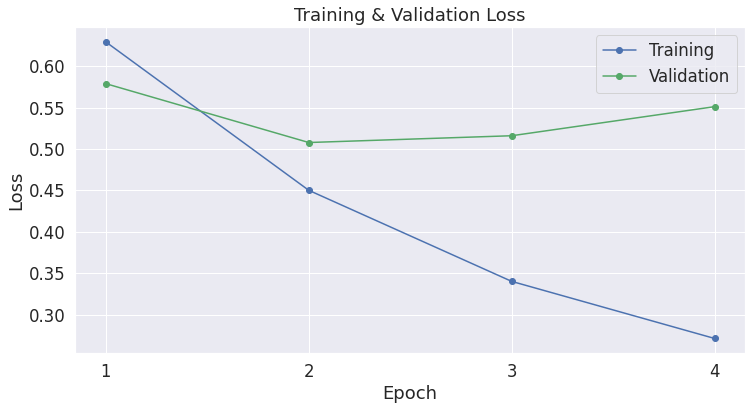

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
data

,sentence,labels
0,anxiety right going away . . .work eat . . .wo...,0
1,hard hard week decided go get happy drink orde...,0
2,extremely suicidal month ago .realized ive rui...,1
3,long terrible relationship going school anxiet...,0
4,specifically yunkai astapor .two city full inn...,0
...,...,...
2595,im scared .scared .want die want die make sens...,0
2596,whatever silly mean everything monty python ba...,0
2597,frozen e menace pour le royaumela franchise de...,0
2598,connected iphone using bluetooth everything se...,0


In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                     num_labels = 2,
                                     output_attentions = False,
                                     output_hidden_states =  False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element